# Recursive Feature Elimination
link:https://machinelearningmastery.com/rfe-feature-selection-in-python/

RFE is a wrapper-type feature selection algorithm. This means that a different machine
learning algorithm is given and used in the core of the method, is wrapped by RFE, and used
to help select features. 

This is in contrast to filter-based feature selections that score each
feature and select those features with the largest (or smallest) score. Technically, RFE is a
wrapper-style feature selection algorithm that also uses filter-based feature selection internally.

RFE works by searching for a subset of features by starting with all features in the training
dataset and successfully removing features until the desired number remains. This is achieved
by fitting the given machine learning algorithm used in the core of the model, ranking features
by importance, discarding the least important features, and re-fitting the model. This process
is repeated until a specified number of features remains.

In [3]:
# evaluate RFE for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5,
random_state=1)
# create pipeline
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[( ' s ' ,rfe),( ' m ' ,model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring= 'accuracy' , cv=cv, n_jobs=-1)
# report performance
print( ' Accuracy: %.3f (%.3f) ' % (mean(n_scores), std(n_scores)))

 Accuracy: 0.889 (0.031) 


## RFE Hyperparameters
In this section, we will take a closer look at some of the hyperparameters you should consider tuning for the RFE method for feature selection and their effect on model performance.

### Explore Number of Features
An important hyperparameter for the RFE algorithm is the number of features to select.

In the previous section, we used an arbitrary number of selected features, five, which matches the number of informative features in the synthetic dataset. In practice, we cannot know the best number of features to select with RFE; instead, it is good practice to test different values.

The example below demonstrates selecting different numbers of features from 2 to 10 on the synthetic binary classification dataset.

>2 0.720 (0.045)
>3 0.816 (0.035)
>4 0.873 (0.032)
>5 0.888 (0.033)
>6 0.888 (0.029)
>7 0.891 (0.028)
>8 0.883 (0.026)
>9 0.884 (0.027)


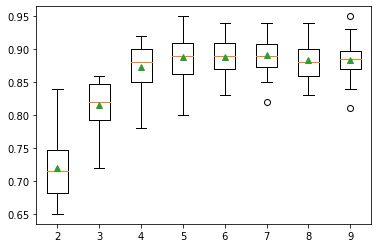

In [1]:

# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
 
# get the dataset
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
	return X, y
 
# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(2, 10):
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
		model = DecisionTreeClassifier()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

### Automatically Select the Number of Features
This can be achieved by performing cross-validation evaluation of different numbers of features as we did in the previous section and automatically selecting the number of features that resulted in the best mean score.

The RFECV class implements this for us.

The RFECV is configured just like the RFE class regarding the choice of the algorithm that is wrapped. Additionally, the minimum number of features to be considered can be specified via the “min_features_to_select” argument (defaults to 1) and we can also specify the type of cross-validation and scoring to use via the “cv” (defaults to 5) and “scoring” arguments (uses accuracy for classification).

In [2]:
# automatically select the number of features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# create pipeline
rfe = RFECV(estimator=DecisionTreeClassifier())
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.886 (0.028)


### Which Features Were Selected
When using RFE, we may be interested to know which features were selected and which were removed.

This can be achieved by reviewing the attributes of the fit RFE object (or fit RFECV object). The “support_” attribute reports true or false as to which features in order of column index were included and the “ranking_” attribute reports the relative ranking of features in the same order.

The example below fits an RFE model on the whole dataset and selects five features, then reports each feature column index (0 to 9), whether it was selected or not (True or False), and the relative feature ranking.

In [3]:
# report which features were selected by RFE
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
# fit RFE
rfe.fit(X, y)
# summarize all features
for i in range(X.shape[1]):
	print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected False, Rank: 5.000
Column: 1, Selected False, Rank: 4.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected False, Rank: 6.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected False, Rank: 2.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected False, Rank: 3.000


### Explore Base Algorithm
There are many algorithms that can be used in the core RFE, as long as they provide some indication of variable importance.

Most decision tree algorithms are likely to report the same general trends in feature importance, but this is not guaranteed. It might be helpful to explore the use of different algorithms wrapped by RFE.

>lr 0.887 (0.031)
>per 0.847 (0.039)
>cart 0.885 (0.034)
>rf 0.861 (0.040)
>gbm 0.888 (0.032)


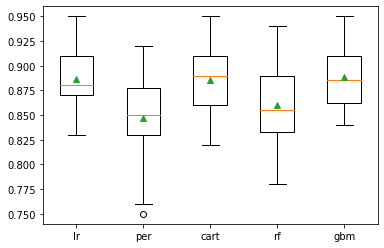

In [4]:
# explore the algorithm wrapped by RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
 
# get the dataset
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
	return X, y
 
# get a list of models to evaluate
def get_models():
	models = dict()
	# lr
	rfe = RFE(estimator=LogisticRegression(), n_features_to_select=5)
	model = DecisionTreeClassifier()
	models['lr'] = Pipeline(steps=[('s',rfe),('m',model)])
	# perceptron
	rfe = RFE(estimator=Perceptron(), n_features_to_select=5)
	model = DecisionTreeClassifier()
	models['per'] = Pipeline(steps=[('s',rfe),('m',model)])
	# cart
	rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
	model = DecisionTreeClassifier()
	models['cart'] = Pipeline(steps=[('s',rfe),('m',model)])
	# rf
	rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
	model = DecisionTreeClassifier()
	models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
	# gbm
	rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=5)
	model = DecisionTreeClassifier()
	models['gbm'] = Pipeline(steps=[('s',rfe),('m',model)])
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()